### Reruns
- I reran this 7/24/24 to get nicer-looking graphs for alexey

# TODOs

- [x] rerun with `force_symmetric=True` where appropriate
- [x] use `f_hat` from approximation algo
- [ ] x2 check the exclusion regions for all `N=1,2,3`

In [1]:
%matplotlib inline

import itertools

import numpy as np
from scipy.stats import beta, truncnorm, uniform

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits

# for exclusion region
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.patches as mpatches

In [9]:
import auction as auction_pkg
auction_pkg.__file__

'/Users/jamesmichelson/github/auctions-qualitative/auction/__init__.py'

In [2]:
from auction import BelloniAuctionApproximation as Approx
from ebm import ExclusiveBuyerMechanismApproximation as EBM

In [3]:
GRAPHPATH_ROOT = '/Users/jamesmichelson/github/phd/ch_auctions_simulations/images/'
OLD_PATH = '/Users/jamesmichelson/github/phd/ch_auctions_simulations/ebm_code/artefacts/runs/'

# What are we doing?

From each run of the approximation algorithm we want three things:
1. revenue 
2. 3D graph of the interim allocations
3. 2D graph of the exclusion region 

In [4]:
def alloc3d(approx, Q1only=False, Q2only=False, fname=None):
    
    try:
        X = approx.V
        N = approx.n_buyers
        J = approx.n_grades
        X_ = approx.V_T_list[0]
        Y_ = approx.V_T_list[1]
        is_ebm = False
    except AttributeError:
        X = approx.X
        N = approx.N
        J = approx.J
        X_ = approx.Xj_ranges[0]
        Y_ = approx.Xj_ranges[1]
        is_ebm = True
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

    n_ticks = 11
    xticks = np.round(np.linspace(X[0][0], X[0][1], n_ticks),4)
    yticks = np.round(np.linspace(X[1][0], X[1][1], n_ticks),4)
    
    if is_ebm:
        Q1 = np.round([q[0] for q in approx.Q],4).reshape((approx.T+1,approx.T+1))
        Q2 = np.round([q[1] for q in approx.Q],4).reshape((approx.T+1,approx.T+1))
    else:
        Q1 = np.round([q[0] for q in approx.Q],4).reshape((approx.T+1,approx.T+1))
        Q2 = np.round([q[1] for q in approx.Q],4).reshape((approx.T+1,approx.T+1)) 
    # Q1Q2 = Q1+Q2


    X_, Y_ = np.meshgrid(X_, Y_)
    if Q1only:
        Z = Q1.T
    elif Q2only:
        Z = Q2.T
    else:
        Z = (Q1+Q2).T

    # ax.plot_surface(X, Y, Z, color='grey') #cmap to make it easier to see ? 

    surf = ax.plot_surface(X_, Y_, Z, cmap='viridis')

    ax.title.set_text(r"$N=%s$, $dim(X)=%s$" % (N, J))
    ax.title.set_size('x-large')

    ax.invert_xaxis()
    ax.set_xlabel(r"$X_1$", size='x-large',  labelpad=10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, ha='right', va='bottom') 

    ax.set_ylabel(r"$X_2$", size='x-large',  labelpad=10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, ha='left', va='bottom')

    ax.set_zlim(0, 1)
    ax.zaxis.set_rotate_label(False)
    if Q1only:
        zlabel = r"$Q_1$"
    elif Q2only:
        zlabel = r"$Q_2$"
    else:
        zlabel = r"$Q_1 + Q_2$"
    ax.set_zlabel(zlabel, rotation=90, size='x-large', labelpad=10)
    ax.zaxis.set_major_formatter('{x:.01f}')
    
    ax.view_init(azim=-35, elev=30)

    # fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.rcParams.update({'font.size': 16})
  
    if fname:
        plt.savefig(fname,bbox_inches="tight")
    plt.show()

In [5]:
def allocation(approx, fname=None):
    
    # TODO handle randomizations! 

    ### data processing code

    # assert approx.n_buyers == 1, "This only works for N=1"
    # assert len(approx.V) == 2, "This only works for K=2"

    eps = 1e-6

    try:
        x, y = np.round(approx.V_T_list[0], 4), np.round(approx.V_T_list[1], 4)
        T = approx.T
    except AttributeError:
        x, y = np.round(approx.Xj_ranges[0], 4), np.round(approx.Xj_ranges[1], 4)
        if approx.T < 1:
            T = int(approx.X[0][1] * ebm.T) - int(approx.X[0][0] * ebm.T) 
        else:
            T = len(approx.Xj_ranges[0])-1
        
    Q1 = np.round(np.array([Qs[0] for Qs in approx.Q]), 4)
    Q2 = np.round(np.array([Qs[1] for Qs in approx.Q]), 4)

    # make alloc
    Q1alloc = (Q1 > eps).astype('int').reshape((T+1,T+1))
    Q2alloc = (Q2 > eps).astype('int').reshape((T+1,T+1))
    zeroalloc = (Q1alloc + Q2alloc == 0).astype('int')

    # fill Q1 alloc
    ixs = [np.any(row) for row in Q1alloc]
    Q1alloc_fillbetween_x = x[ixs]
    Q1alloc_fillbetween_y1 = []
    for i, val in enumerate(ixs):
        if val:
            Q1alloc_fillbetween_y1.append(
                min(y[Q1alloc[i] > 0]))
    Q1alloc_fillbetween_y1 = np.array(Q1alloc_fillbetween_y1)
    Q1alloc_fillbetween_y2 = []
    for i, val in enumerate(ixs):
        if val:
            Q1alloc_fillbetween_y2.append(
                max(y[Q1alloc[i] > 0]))
    Q1alloc_fillbetween_y2 = np.array(Q1alloc_fillbetween_y2)

    # fill Q2 alloc
    ixs = [np.any(row) for row in Q2alloc]
    Q2alloc_fillbetween_x = x[ixs]
    Q2alloc_fillbetween_y1 = []
    for i, val in enumerate(ixs):
        if val:
            Q2alloc_fillbetween_y1.append(
                min(y[Q2alloc[i] > 0]))
    Q2alloc_fillbetween_y1 = np.array(Q2alloc_fillbetween_y1)
    Q2alloc_fillbetween_y2 = []
    for i, val in enumerate(ixs):
        if val:
            Q2alloc_fillbetween_y2.append(
                max(y[Q2alloc[i] > 0]))
    Q2alloc_fillbetween_y2 = np.array(Q2alloc_fillbetween_y2)

    # fill exclusion region
    ixs = [np.any(row) for row in zeroalloc]
    zeroalloc_fillbetween_x = x[ixs]
    zeroalloc_fillbetween_y1 = []
    for i, val in enumerate(ixs):
        if val:
            zeroalloc_fillbetween_y1.append(
                min(y[zeroalloc[i] > 0]))
    zeroalloc_fillbetween_y1 = np.array(zeroalloc_fillbetween_y1)
    zeroalloc_fillbetween_y2 = []
    for i, val in enumerate(ixs):
        if val:
            zeroalloc_fillbetween_y2.append(
                max(y[zeroalloc[i] > 0]))
    zeroalloc_fillbetween_y2 = np.array(zeroalloc_fillbetween_y2)

    ### graphing code
    
    try:
        V = approx.V
    except AttributeError:
        V = approx.X

    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.title.set_text(r"Allocation $X_1 \times X_2=%s\times%s$ (T=%s)" % \
                      (V[0], V[1], approx.T))
    ax.title.set_size('large')
    ax.set(xlabel=r"$X_1$", ylabel=r"$X_2$")

    xaxis_ticks = np.round(x, 2)
    yaxis_ticks = np.round(y, 2)

    ax.set_xlim(xaxis_ticks[0], xaxis_ticks[-1])
    ax.set_xticks(xaxis_ticks)
    ax.set_xticklabels(xaxis_ticks, rotation=-45)

    ax.set_ylim(yaxis_ticks[0], yaxis_ticks[-1])
    ax.set_yticks(yaxis_ticks)

    q1_patch = mpatches.Patch(color='blue', label=r'only $Q_1(x) > 0$')
    q2_patch = mpatches.Patch(color='red', label=r'only $Q_1(x) > 0$')
    random_patch = mpatches.Patch(color='purple', label=r'$Q_1(x) + Q_2(x) > 0$')
    zero_patch = mpatches.Patch(color='black', label='Exclusion region')
    ax.legend(handles=[q1_patch,q2_patch,random_patch,zero_patch], prop={'size': 12})

    plt.rcParams.update({'font.size': 10})
    plt.rc('legend', fontsize=10)

    plt.fill_between(
        x=Q1alloc_fillbetween_x,
        y1=Q1alloc_fillbetween_y1,
        y2=Q1alloc_fillbetween_y2,
        color='blue',
        alpha=.8)

    plt.fill_between(
        x=Q2alloc_fillbetween_x,
        y1=Q2alloc_fillbetween_y1,
        y2=Q2alloc_fillbetween_y2,
        color='red',
        alpha=.7)

    plt.fill_between(
        x=zeroalloc_fillbetween_x,
        y1=zeroalloc_fillbetween_y1,
        y2=zeroalloc_fillbetween_y2,
        color='black',
        alpha=.8)

    if fname:
        plt.savefig(fname,bbox_inches="tight")
    plt.show()

In [6]:
def ebm_revenue(ebm, p, approx_f=None, costs=None):
    # simulated second price auction
    total = 0
    for ix1, x1 in enumerate(ebm.X_iter):
        for ix2, x2 in enumerate(ebm.X_iter):

            beta1 = [x1[0]-p[0],x1[1]-p[1]]
            beta1_max = np.max(beta1)
            beta1_max_j = np.argmax(beta1)
            beta2 = [x2[0]-p[0],x2[1]-p[1]]
            beta2_max = np.max(beta2)
            beta2_max_j = np.argmax(beta2)  

            # find winner
            max_betas = [beta1_max, beta2_max]
            winner_i = np.argmax(max_betas)
            winner_j = [beta1_max_j, beta2_max_j][winner_i]

            # pays 2nd highest beta
            if max_betas[winner_i] >= 0 - 1e-10:
                loser_i = (winner_i - 1) * -1
                loser_max_beta_j = max(max_betas[loser_i], 0)
                revenue = p[winner_j] + loser_max_beta_j
                
                # take into account costs
                if costs:
                    revenue -= costs[winner_j]
                
            else:
                revenue = 0
                
            if approx_f is not None:
                # makes use of indexing (faster)
                # this is also closer to approx result ...
                total += revenue * approx_f[ix1] * approx_f[ix2]
            else:
                total += revenue * np.power(ebm.delta_1d,4) * ebm.f(x1) * ebm.f(x2) \
                    * ebm.numerical_adjustment(ix1) * ebm.numerical_adjustment(ix2)

    return total

# Runs

1. symmetric, independent, uniform (pavlov)  ($U[0,1]^2$ and $U[2,3]^2$)
2. symmetric, independent, beta
3. symmetric, correlated, uniform
4. asymmetric, independent, uniform (belloni)
5. asymmetric, independent, truncorm

In [7]:
Ts = [5, 10, 15, 20]

## 1a. symmetric, independent, uniform $U[0,1]^2$

In [8]:
Approx.from_file(OLD_PATH + 'symmetric_independent_unif_01_%s.pkl' % 5)

AttributeError: 'rv_frozen' object has no attribute 'pdf'

In [10]:
setting1 = []
for T in Ts: 
    setting1.append(Approx.from_file(OLD_PATH + 'symmetric_independent_unif_01_%s.pkl' % T))

AttributeError: 'rv_frozen' object has no attribute 'pdf'

In [10]:
# revenue
for r in setting1:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 0.66094
T=10: 0.625929
T=15: 0.612877
T=20: 0.606033


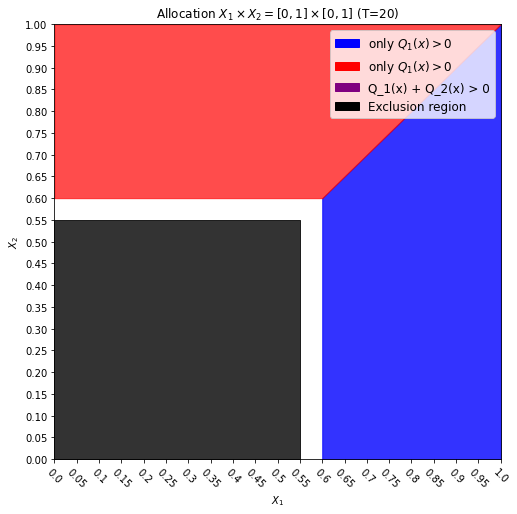

In [12]:
# get exclusion region 
# don't need to write it to disk (just visually check price)
ex1 = setting1[-1]
allocation(ex1)  

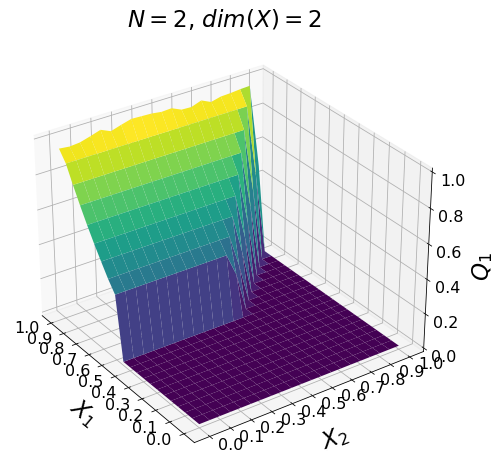

In [16]:
# extra graph of Q1
alloc3d(ex1, True, fname=GRAPHPATH_ROOT + 'symmetric_independent_unif_01_Q1.png')

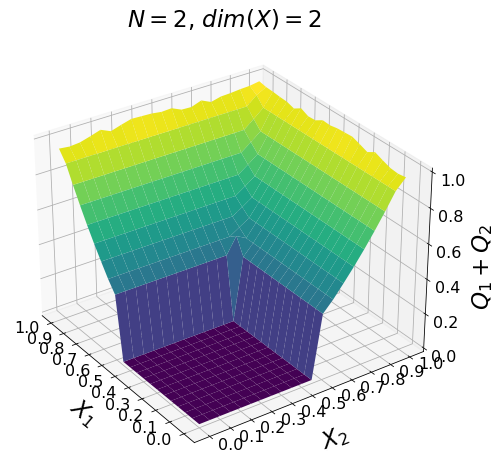

In [15]:
# allocation (from simulation)
alloc3d(ex1, fname=GRAPHPATH_ROOT + 'symmetric_independent_unif_01.png')

In [18]:
def unif(x):
    return 1

# allocation (from EBM)
ebm = EBM(
    N=ex1.n_buyers,
    X=ex1.V,
    c=ex1.costs,
    T=50,
    f=unif)

In [20]:
ebm.T

50

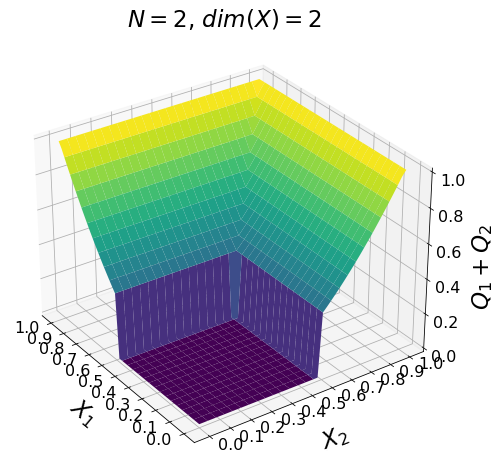

In [21]:
# look at graph (get p)
p = [.6,.6]
Qs = ebm.obj(p)[1] # run it to set attributes

alloc3d(ebm, fname=GRAPHPATH_ROOT + 'symmetric_independent_unif_01_ebm.png')

In [22]:
ebm_revenue(ebm, p)

0.5890515691960928

In [23]:
ebm_revenue(ebm, p, ex1.f_hat)

IndexError: list index out of range

In [24]:
np.round(0.5890515691960928, 6)

0.589052

## 1b. symmetric, independent, uniform $U[2,3]^2$

In [25]:
setting1b = []
for T in Ts: 
    setting1b.append(Approx.from_file(OLD_PATH + 'symmetric_independent_unif_23_%s.pkl' % T))

In [26]:
# revenue
for r in setting1b:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 2.622409
T=10: 2.58287
T=15: 2.569334
T=20: 2.562314


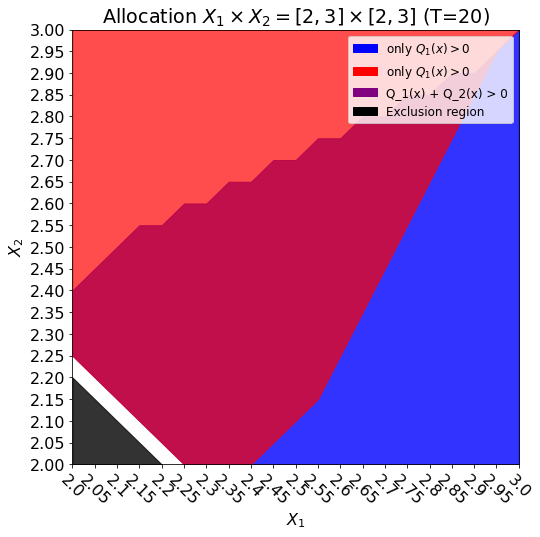

In [28]:
# get exclusion region 
# don't need to write it to disk (just visually check price)
ex1b = setting1b[-1]
allocation(ex1b)  

Fuck.

The asymmetric quality of the graph is likely just the plotting algorithm. Not worried about that.

The issue is that the shape of the randomization region is WRONG. See (Pavlov 2011, Figure 2).

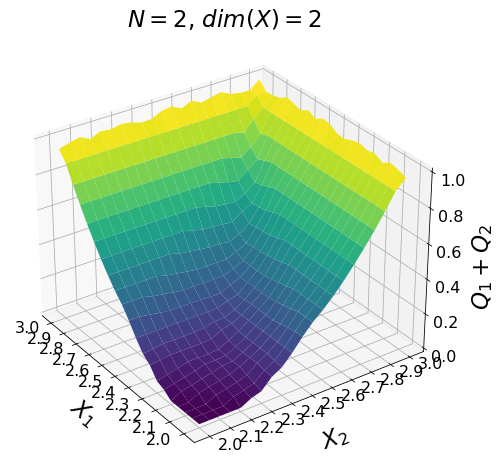

In [33]:
# allocation (from simulation)
alloc3d(ex1b, fname=GRAPHPATH_ROOT + 'symmetric_independent_unif_23.png')

In [30]:
def unif(x):
    return 1

# allocation (from EBM)
ebm1b = EBM(
    N=ex1b.n_buyers,
    X=ex1b.V,
    c=ex1b.costs,
    T=50,
    f=unif)

We know this involves randomization! So it shouldn't work. But we can pick $r$ anyways... 

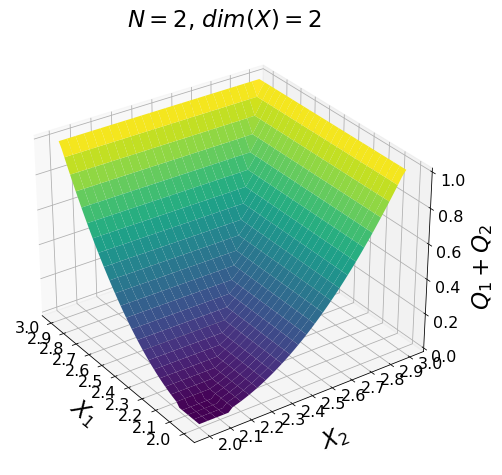

In [31]:
# look at graph (get p)
p = [2.15,2.15]
Qs = ebm1b.obj(p)[1] # run it to set attributes

alloc3d(ebm1b, fname=GRAPHPATH_ROOT + 'symmetric_independent_unif_23_ebm.png')

In [32]:
ebm_revenue(ebm1b, p)

2.5344992638150967

In [34]:
np.round(2.5344992638150967, 6)

2.534499

In [35]:
2.562314 / 2.534499

1.0109745555235967

## 2. symmetric, independent, beta

In [39]:
setting2 = []
for T in Ts: 
    setting2.append(Approx.from_file(OLD_PATH + 'symmetric_independent_beta_%s.pkl' % T))

In [40]:
# revenue
for r in setting2:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 0.448709
T=10: 0.418815
T=15: 0.406948
T=20: 0.400615


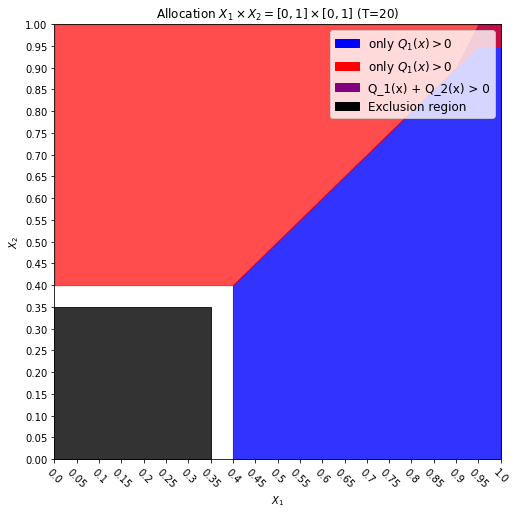

In [41]:
# get exclusion region 
# don't need to write it to disk (just visually check price)
ex2 = setting2[-1]
allocation(ex2)  

In [44]:
ex2.force_symmetric

True

### <span style="color:red"> WARNING: exclusion region fucked </span>

- [x] rerun with `force_symmetric=True`

What is going on?!??

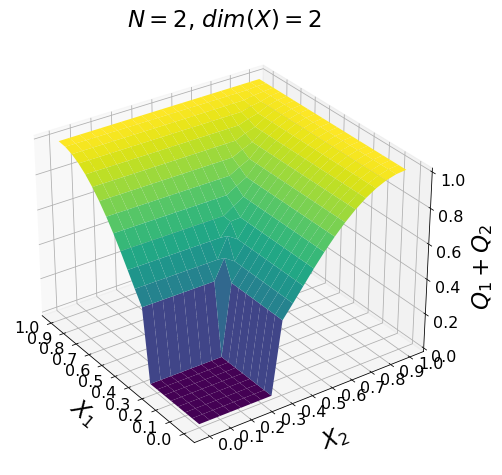

In [46]:
# allocation (from simulation)
alloc3d(ex2, fname=GRAPHPATH_ROOT + 'symmetric_independent_beta.png')

In [47]:
f_beta = beta(1,2).pdf

def f(x):
    if len(x) == 1:
        return beta(1,2).pdf(x)
    else:
        v = f_beta(x)
        return v[0] * v[1]  # iid

# allocation (from EBM)
ebm2 = EBM(
    N=ex2.n_buyers,
    X=ex2.V,
    c=ex2.costs,
    T=50,
    f=f)

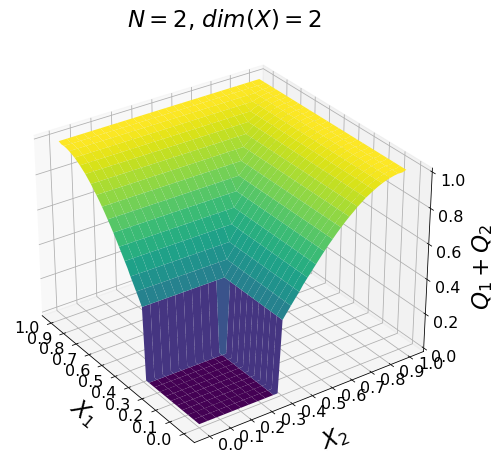

In [48]:
# look at exclusion region (get p)
p2 = [.4,.4]
Qs = ebm2.obj(p2)[1] # run it to set attributes

alloc3d(ebm2, fname=GRAPHPATH_ROOT + 'symmetric_independent_beta_ebm.png')

In [49]:
ebm_revenue(ebm2, p2)

0.3850451538956287

In [56]:
import itertools
from auction.discrete import discretize, f_hat

new_T = 50
V_T_list, _ = discretize(ex2.V, new_T)
V_T = list(itertools.product(*V_T_list))
f_ = f_hat(ex2.f, V_T, ex2.corr, new_T, ex2.n_grades)

ebm_revenue(ebm2, p2, f_)
# 0.3915063091875334 (old)

0.3850451538956287

In [57]:
np.round(0.3850451538956287,6)

0.385045

## 3. symmetric, correlated, uniform

In [27]:
from auction.util import corrU

In [58]:
setting3 = []
for T in Ts: 
    setting3.append(Approx.from_file(OLD_PATH + 'symmetric_correlated_unif_%s.pkl' % T))

In [59]:
# revenue
for r in setting3:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 0.75159
T=10: 0.718683
T=15: 0.705905
T=20: 0.698962


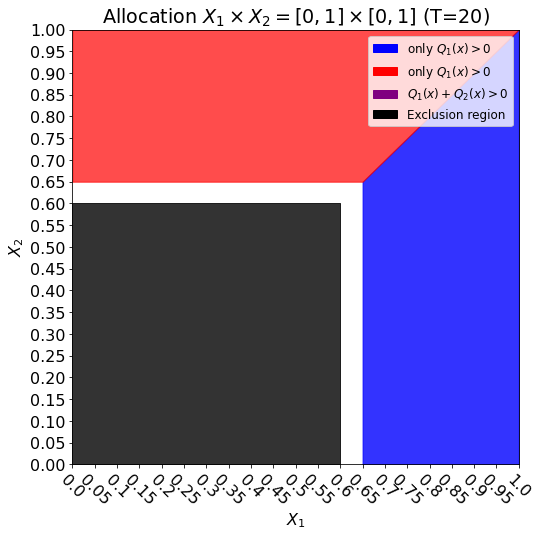

In [60]:
# get exclusion region 
# don't need to write it to disk (just visually check price)
ex3 = setting3[-1]
allocation(ex3)  

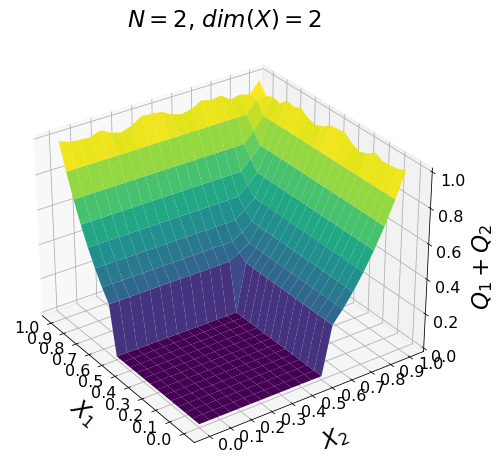

In [63]:
# allocation (from simulation)
alloc3d(ex3, fname=GRAPHPATH_ROOT + 'symmetric_correlated_unif.png')

In [64]:
def f(x):
    return x[0] + x[1]

# allocation (from EBM)
ebm3 = EBM(
    N=ex3.n_buyers,
    X=ex3.V,
    c=ex3.costs,
    T=50,
    f=f)

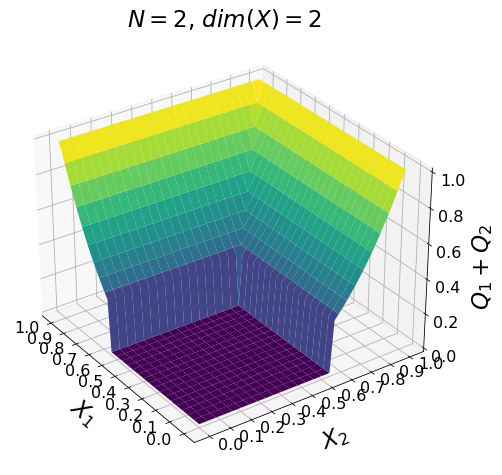

In [65]:
# look at exclusion region (get p)
p3 = [.65,.65]
Qs = ebm3.obj(p3)[1] # run it to set attributes

alloc3d(ebm3, fname=GRAPHPATH_ROOT + 'symmetric_correlated_unif_ebm.png')

In [66]:
ebm_revenue(ebm3, p3)

0.6761917333923022

In [68]:
np.round(0.6761917333923022, 6)

0.676192

In [69]:
import itertools
from auction.discrete import discretize, f_hat

new_T = 50
V_T_list, _ = discretize(ex3.V, new_T)
V_T = list(itertools.product(*V_T_list))
f_ = f_hat(ex3.f, V_T, ex3.corr, new_T, ex3.n_grades)

ebm_revenue(ebm3, p3, f_)

# ebm_revenue(ebm3, p3, ex3.f_hat)
# 0.6864374781250177

0.6761917333923022

## 4. asymmetric, independent, uniform (belloni)

In [47]:
from auction.util import belloni_f

In [71]:
setting4 = []
for T in Ts: 
    setting4.append(Approx.from_file(OLD_PATH + 'asymmetric_independent_belloni_%s.pkl' % T))

In [72]:
# revenue
for r in setting4:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 6.02496
T=10: 5.941549
T=15: 5.91222
T=20: 5.896792


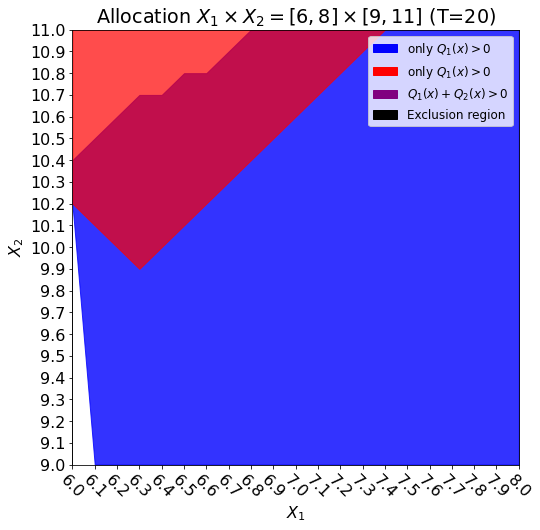

In [73]:
# get exclusion region 
ex4 = setting4[-1]
allocation(ex4, fname=GRAPHPATH_ROOT + 'belloni_alloc_n2.png' )  

In [74]:
ex4.force_symmetric

False

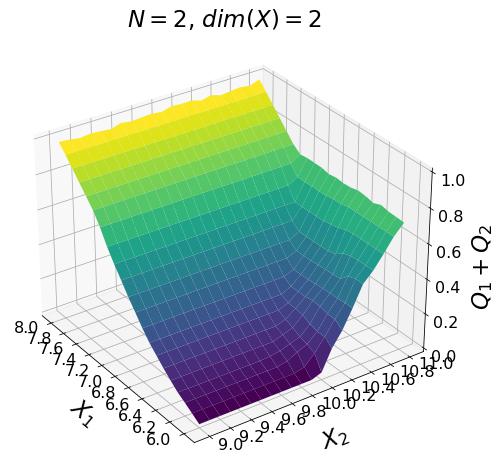

In [76]:
# allocation (from simulation)
alloc3d(ex4, fname=GRAPHPATH_ROOT + 'asymmetric_independent_belloni.png')

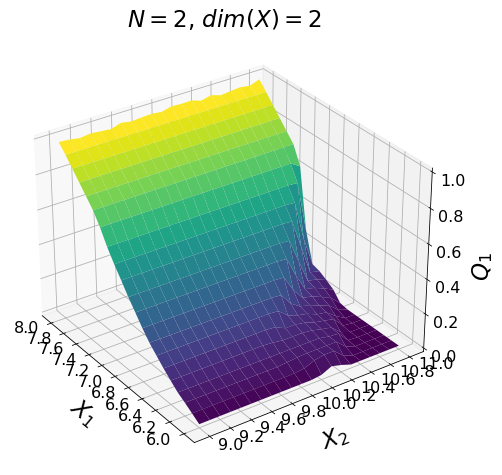

In [77]:
# allocation (from simulation)
alloc3d(ex4, True, fname=GRAPHPATH_ROOT + 'asymmetric_independent_belloni_Q1.png')

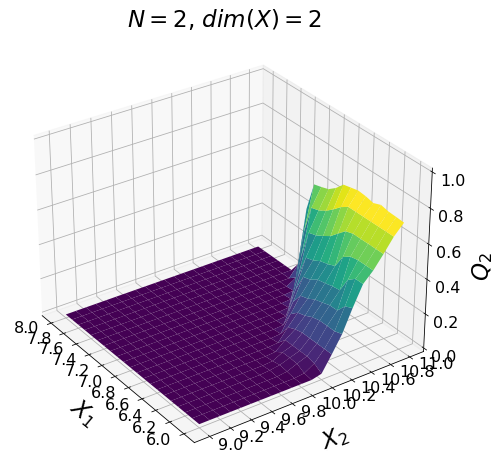

In [78]:
# allocation (from simulation)
alloc3d(ex4, False, True, fname=GRAPHPATH_ROOT + 'asymmetric_independent_belloni_Q2.png')

In [79]:
def f(x):
    return 1/4

# allocation (from EBM)
ebm4 = EBM(
    N=ex4.n_buyers,
    X=ex4.V,
    c=ex4.costs,
    T=50,
    f=f)

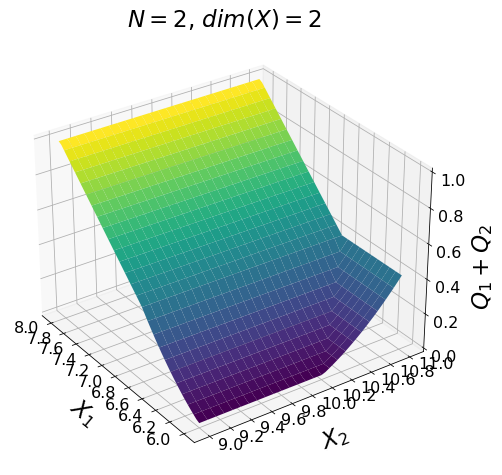

In [80]:
# look at exclusion region (get p)
p4 = [6,10.2]
res = ebm4.obj(p4)[1] # run it to set attributes

alloc3d(ebm4, fname=GRAPHPATH_ROOT + 'asymmetric_independent_belloni_ebm.png')

In [81]:
ebm_revenue(ebm4, p4, costs=ex4.costs)

5.805032389429519

In [82]:
import itertools
from auction.discrete import discretize, f_hat

new_T = 50
V_T_list, _ = discretize(ex4.V, new_T)
V_T = list(itertools.product(*V_T_list))
f_ = f_hat(ex4.f, V_T, ex4.corr, new_T, ex4.n_grades)

ebm_revenue(ebm4, p4, f_, costs=ex4.costs)
# 5.814852226561947 (old; same)

5.805032389429519

In [116]:
np.round(5.814852226561947,6)

5.814852

## 5. asymmetric, independent, truncorm

In [83]:
setting5 = []
for T in Ts: 
    setting5.append(Approx.from_file(OLD_PATH + 'asymmetric_independent_truncnorm_%s.pkl' % T))

In [84]:
# revenue
for r in setting5:
    print('T=%s: %s' % (r.T, np.round(r.opt,6)))

T=5: 2.779996
T=10: 2.749451
T=15: 2.736171
T=20: 2.729342


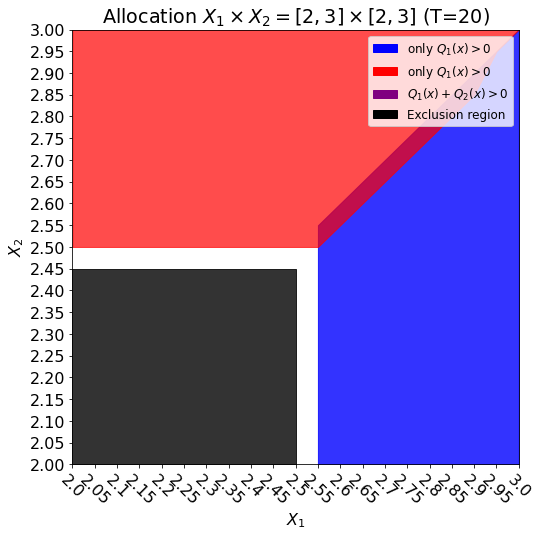

In [85]:
# get exclusion region 
# don't need to write it to disk (just visually check price)
ex5 = setting5[-1]
allocation(ex5)  

In [86]:
ex5.force_symmetric

False

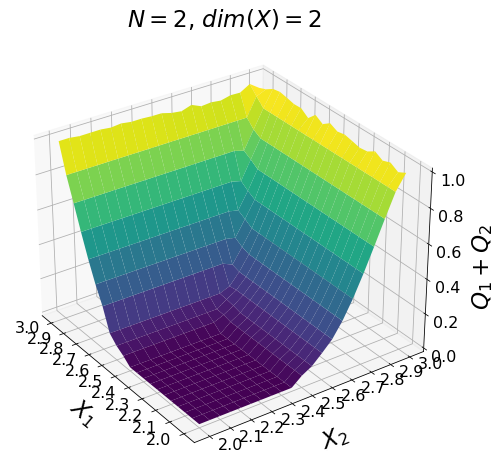

In [89]:
# allocation (from simulation)
alloc3d(ex5, fname=GRAPHPATH_ROOT + 'asymmetric_independent_truncnorm.png')

In [95]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


f_tnrom1 = get_truncated_normal(2.3, 1, 2, 3)
f_tnrom2 = get_truncated_normal(2.8, .2, 2, 3)

def f5(x):
    return f_tnrom1.pdf(x[0]) * f_tnrom2.pdf(x[1])

# allocation (from EBM)
ebm5 = EBM(
    N=ex5.n_buyers,
    X=ex5.V,
    c=ex5.costs,
    T=50,
    f=f5)

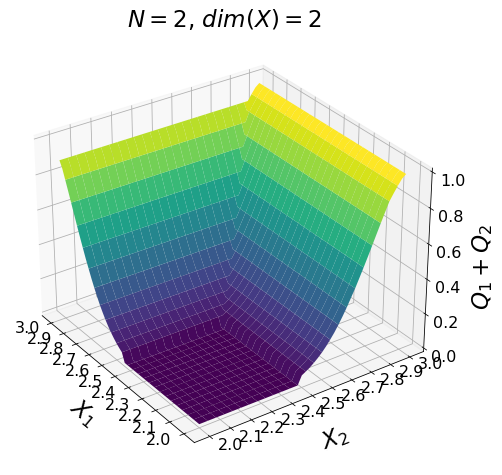

In [96]:
# look at exclusion region (get p)
# p5 = [2.55,2.5]
p5 = [2.56,2.5]  # need 2.56 for grid with T=50
Qs = ebm5.obj(p5)[1] # run it to set attributes

alloc3d(ebm5, fname=GRAPHPATH_ROOT + 'asymmetric_independent_truncnorm_ebm.png')

In [97]:
ebm_revenue(ebm5, p5)  # this isn't normalized... don't use??? (this takes ~1hr)

2.579209557220777

In [98]:
np.round(2.579209557220777,6)

2.57921

In [131]:
# ebm_revenue(ebm5, p5, ex5.f_hat)
# 2.7273157050405117 (old)

2.7273157050405117

In [142]:
np.round(2.7273157050405117,6)

2.727316